In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
import numpy as np

# Load your dataset
df = pd.read_csv('/content/classified_tweet (2).csv')

df['Tweet'] = df['Tweet'].astype(str)  # Convert all tweets to strings
df['Tweet'].fillna('', inplace=True)    # Replace any missing values with empty strings

# Split the dataset into features and labels
X = df['Tweet'].values
y = df['Classification'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert data to BERT InputExample format
def convert_data_to_examples(train_texts, test_texts, train_labels, test_labels):
    train_InputExamples = [InputExample(guid=None,
                                        text_a=text,
                                        text_b=None,
                                        label=label) for text, label in zip(train_texts, train_labels)]

    test_InputExamples = [InputExample(guid=None,
                                       text_a=text,
                                       text_b=None,
                                       label=label) for text, label in zip(test_texts, test_labels)]

    return train_InputExamples, test_InputExamples

train_InputExamples, test_InputExamples = convert_data_to_examples(X_train, X_test, y_train, y_test)

# Convert to BERT InputFeatures format
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,  # BERT's max length is 512
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                     input_dict["token_type_ids"],
                                                     input_dict["attention_mask"])

        features.append(
            InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label)
        )

    def gen():
        for f in features:
            yield (
                {
                    'input_ids': f.input_ids,
                    'attention_mask': f.attention_mask,
                    'token_type_ids': f.token_type_ids
                },
                f.label,
            )

    output_signature = (
        {
            'input_ids': tf.TensorSpec(shape=[None], dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=[None], dtype=tf.int32),
            'token_type_ids': tf.TensorSpec(shape=[None], dtype=tf.int32),
        },
        tf.TensorSpec(shape=[], dtype=tf.int64)
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

# Convert to TensorFlow dataset
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

# Get the total number of steps per epoch
steps_per_epoch = len(X_train) // 32  # Assuming batch_size=32
validation_steps = len(X_test) // 32  # Assuming batch_size=32

# Load BERT Base model with dropout to avoid overfitting
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(np.unique(y)))

# Add learning rate scheduler and early stopping
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=3e-5,
    decay_steps=steps_per_epoch * 3,  # Decay over the course of the entire training
    end_learning_rate=1e-7
)

# Compile the model with optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with learning rate schedule and early stopping
history = model.fit(train_data,
                    epochs=10,  # Increased the number of epochs
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_data,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])  # Add early stopping

# Evaluate the model
y_pred = model.predict(test_data).logits
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1192/1192 [==============================] - 1022s 829ms/step - loss: 0.4340 - accuracy: 0.8132 - val_loss: 0.2751 - val_accuracy: 0.8849
Epoch 2/10
1192/1192 [==============================] - 984s 826ms/step - loss: 0.1837 - accuracy: 0.9310 - val_loss: 0.2204 - val_accuracy: 0.9191
Epoch 3/10
   2/1192 [..............................] - ETA: 4:43 - loss: 0.2853 - accuracy: 0.9268 

299/299 [==============================] - 84s 270ms/step
Accuracy: 0.9191739176014257
F1 Score: 0.9200244513811752
Precision: 0.921183525775157
Recall: 0.9191739176014257


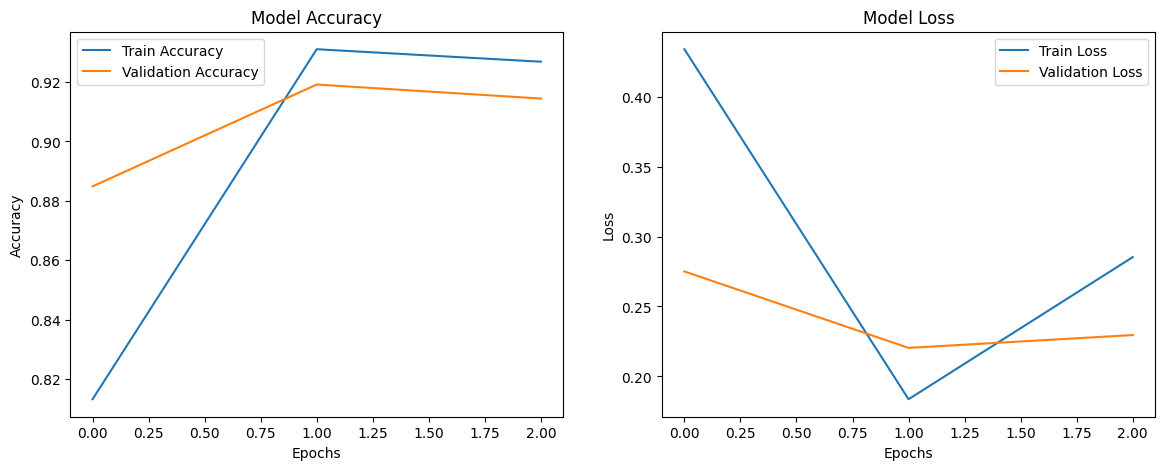

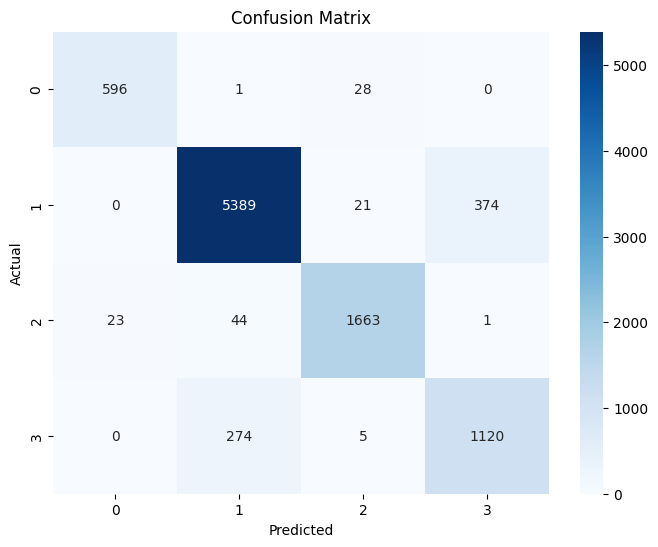

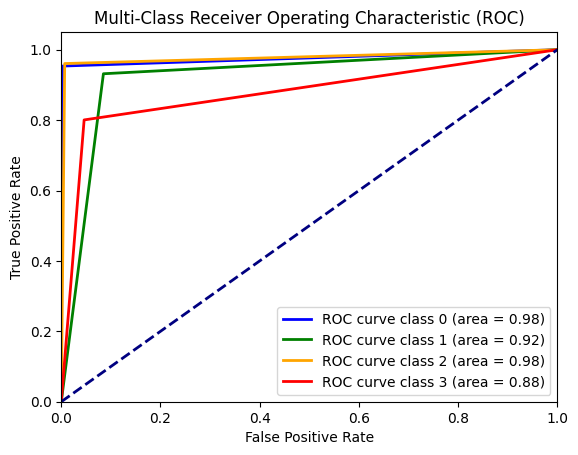

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import seaborn as sns
# Plot accuracy and loss graphs
plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Binarize the output labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Assuming 4 classes (0, 1, 2, 3)
n_classes = y_test_bin.shape[1]

# Binarize predictions
y_pred_bin = label_binarize(y_pred_classes, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'orange', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve class {i} (area = {roc_auc[i]:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configure plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()